In [1]:
import pandas as pd
import seaborn as sns
import cdt
import networkx as nx
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

No GPU automatically detected. Setting SETTINGS.GPU to 0, and SETTINGS.NJOBS to cpu_count.


## EDA Conclusions

#### Session data summary:

count    10000.000000 \
mean        16.788000  \
std          3.808321 \
min         10.000000 \
25%         13.000000 \
50%         20.000000 \
75%         20.000000 \
max         20.000000 

#### Songs data
Unique songs = 167880
Skipped songs = 33.29%

### Skip Analysis
Relation between the skips \
if skip_1 == True then skip_2 = True \
if skip_2 == True then skip_3 = True 

<!-- except for track_id_clean = t_32ef9f23-ba4f-4804-b12f-0fd660cc9f19 -->

Of the songs skipped, 50% of the songs were skipped very briefly, 25% skipped briefly, 25% most track played

#### Skip data vs Discrete features
Session position:\
skip_1 = \
skip_2 = \
skip_3 = 

Hour of the day:\
skip_1 = sharp decline rapidly after 10\
skip_2 = \
skip_3 = 

In [3]:
# read data
df = pd.read_csv('../../data/training_set/log_mini.csv')

In [4]:
df.columns

Index(['session_id', 'session_position', 'session_length', 'track_id_clean',
       'skip_1', 'skip_2', 'skip_3', 'not_skipped', 'context_switch',
       'no_pause_before_play', 'short_pause_before_play',
       'long_pause_before_play', 'hist_user_behavior_n_seekfwd',
       'hist_user_behavior_n_seekback', 'hist_user_behavior_is_shuffle',
       'hour_of_day', 'date', 'premium', 'context_type',
       'hist_user_behavior_reason_start', 'hist_user_behavior_reason_end'],
      dtype='object')

In [5]:
# session data summary
df.session_id.value_counts().describe()

count    10000.000000
mean        16.788000
std          3.808321
min         10.000000
25%         13.000000
50%         20.000000
75%         20.000000
max         20.000000
Name: session_id, dtype: float64

In [6]:
# song data
print(f'Total number of songs:', len(df))
skipped_num = df[df['not_skipped'] == True]['not_skipped'].count()
non_skipped_num = df[df['not_skipped'] == False]['not_skipped'].count()
skip_percent = (skipped_num/(non_skipped_num + skipped_num))*100
print('Skipped percent: ', skip_percent)

Total number of songs: 167880
Skipped percent:  33.28806290207291


In [7]:
# skip 1, skip 2, skip 3 relation
df[df['skip_1'] == True]['skip_2'].describe()
df[df['skip_2'] == True]['skip_3'].describe()

count     86824
unique        2
top        True
freq      86823
Name: skip_3, dtype: object

In [8]:
df[df['skip_3'] == True]['skip_2'].describe()

count     108850
unique         2
top         True
freq       86823
Name: skip_2, dtype: object

In [65]:
# skip distributions
# songs that have been skipped

# has skipped songs
df['is_skip'] = df.apply(lambda x : x.skip_1 or x.skip_2 or x.skip_3, axis=1)
skipped_df = df[df['is_skip'] == True]

# add skip column
def f(s1, s2, s3):
    if s1:
        return 1
    elif s2:
        return 2
    elif s3:
        return 3
    return 0
    
skipped_df['skip'] = skipped_df.apply(lambda x: f(x.skip_1, x.skip_2, x.skip_3), axis=1)
print(skipped_df['skip'].value_counts())
skipped_df['skip'].describe()

1    70762
3    22027
2    16062
Name: skip, dtype: int64


count    108851.000000
mean          1.552278
std           0.807460
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max           3.000000
Name: skip, dtype: float64

In [64]:
skipped_df['skip'].value_counts

1    70762
3    22027
2    16062
Name: skip, dtype: int64

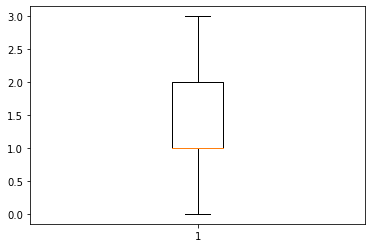

In [59]:
plt.boxplot(skipped_df['skip'])
plt.show()

In [ ]:



# deal context switch separately

# pauses before play vs 

# hour of the day

# context type

In [170]:
def skip_vs_discrete_feat(x_col):
    skipped_df[skipped_df['skip'] == 1][x_col].value_counts()
    y1_data = skipped_df[skipped_df['skip'] == 1][x_col].value_counts()
    y2_data = skipped_df[skipped_df['skip'] == 2][x_col].value_counts()
    y3_data = skipped_df[skipped_df['skip'] == 3][x_col].value_counts()
    return y1_data, y2_data, y3_data

def plot_discrete_feat(y1_data, y2_data, y3_data, x_col, title):
    fig = plt.figure()
    plt.plot(y1_data.index.sort_values(), y1_data.values)
    plt.plot(y2_data.index.sort_values(), y2_data.values)
    plt.plot(y3_data.index.sort_values(), y3_data.values)
    plt.xlabel(x_col)
    plt.ylabel('frequency')
    plt.legend(['skipped very briefly','skipped briefly','mostly played'])
    plt.title(title)
    return fig


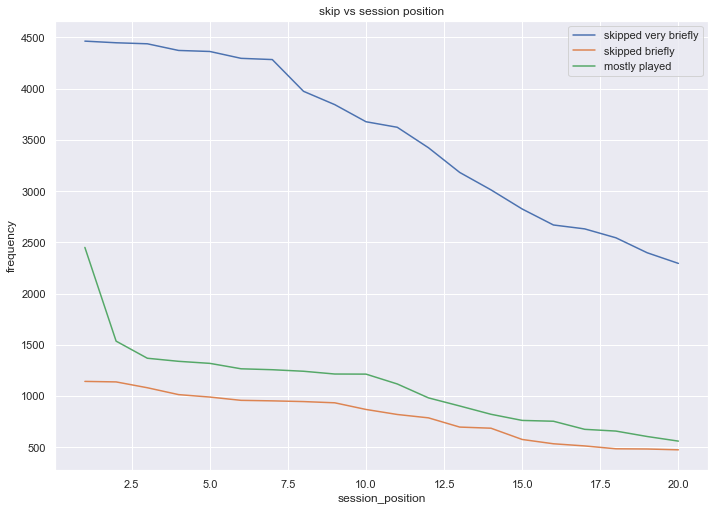

In [174]:
x_col = 'session_position'
y1_data, y2_data, y3_data = skip_vs_discrete_feat(x_col=x_col)
p = plot_discrete_feat(y1_data, y2_data, y3_data, x_col, 'skip vs session position')
plt.show()

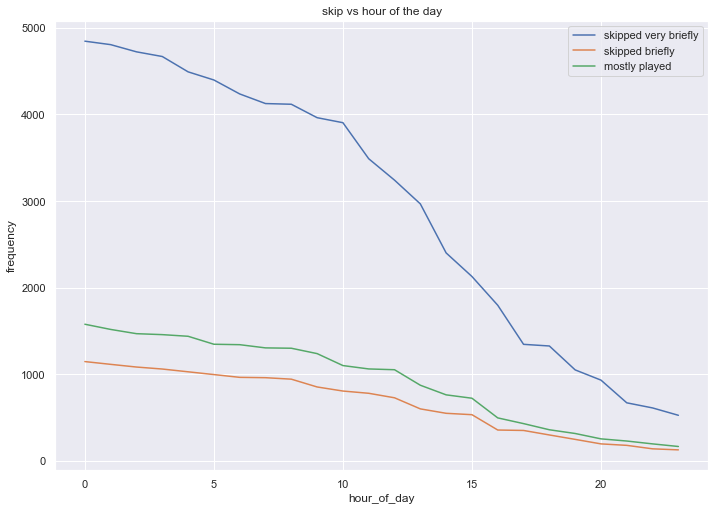

In [175]:
x_col = 'hour_of_day'
y1_data, y2_data, y3_data = skip_vs_discrete_feat(x_col=x_col)
p = plot_discrete_feat(y1_data, y2_data, y3_data, x_col, 'skip vs hour of the day')
plt.show()

In [22]:
sns.pairplot(penguins, hue="species")
sns.set(rc={'figure.figsize':(11.7,8.27)})

count    10000.000000
mean        16.788000
std          3.808321
min         10.000000
25%         13.000000
50%         20.000000
75%         20.000000
max         20.000000
Name: session_id, dtype: float64

In [10]:
skipped_df.to_csv('../../data/session-df-ak.csv')